<a href="https://colab.research.google.com/github/ramirorudiger/RamiroNMTCG/blob/main/TCC_Ramiro_NMT_Code_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

**Intro**

Neste projeto utilizo técnicas de tradução de máquina com redes neurais (neuro machine translation) para traduzir uma linguagem natural para código python. 

O framework utilizado aqui foi o pytorch (https://pytorch.org/)

In [ ]:
#imports
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Download arquivos de dados


In [ ]:
!wget https://raw.githubusercontent.com/ramirorudiger/RamiroNMTCG/main/data/django_data.csv
!wget https://raw.githubusercontent.com/ramirorudiger/RamiroNMTCG/main/data/django_data_test.csv
!wget https://raw.githubusercontent.com/ramirorudiger/RamiroNMTCG/main/data/conala_test.csv
!wget https://raw.githubusercontent.com/ramirorudiger/RamiroNMTCG/main/data/conala_train.csv
!wget https://raw.githubusercontent.com/ramirorudiger/RamiroNMTCG/main/data/django_train2.csv
!wget https://raw.githubusercontent.com/ramirorudiger/RamiroNMTCG/main/data/django_test2.csv

--2023-03-15 17:58:55--  https://raw.githubusercontent.com/ramirorudiger/RamiroNMTCG/main/data/django_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1960932 (1.9M) [text/plain]
Saving to: ‘django_data.csv’

django_data.csv     100%[===================>]   1.87M  --.-KB/s    in 0.02s   

2023-03-15 17:58:56 (77.9 MB/s) - ‘django_data.csv’ saved [1960932/1960932]

--2023-03-15 17:58:56--  https://raw.githubusercontent.com/ramirorudiger/RamiroNMTCG/main/data/django_data_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

Funções de limpeza de código

In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"([.!?])", r"", s)
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

print(normalizeString('def soma(self, a, b):\nself.soma(a, b)'))

def soma self a b self soma a b 


Estrutura de dados da linguagem

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] if word in lang.word2index else EMP_token for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


SOS_token = 0
EOS_token = 1
EMP_token = 2


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "EMP"}
        self.n_words = 3  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Carga do dataset na estrutura de dados

In [ ]:
import pandas as pd



def readLangs(lang1, lang2, train_file, reverse=False):
    df = pd.read_csv(train_file, delimiter=',')
    df.dropna(inplace=True)
    df = df.reset_index()  # make sure indexes pair with number of rows

    pairs = [[normalizeString(row['nl']), normalizeString(row['code'])] for index, row in df.iterrows()]
    
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    max_length = 0
    for item in pairs:
        if len(item[0]) > max_length:
            max_length = len(item[0])
        if len(item[1]) > max_length:
            max_length = len(item[1])
    print('maior número: %d' % max_length)
    return input_lang, output_lang, pairs, max_length

def prepareData(lang1, lang2, train_file, reverse=False):
    input_lang, output_lang, pairs, max_length = readLangs(lang1, lang2, train_file, reverse)
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs, max_length



Classe do encoder e do Decoder da arquitetura:


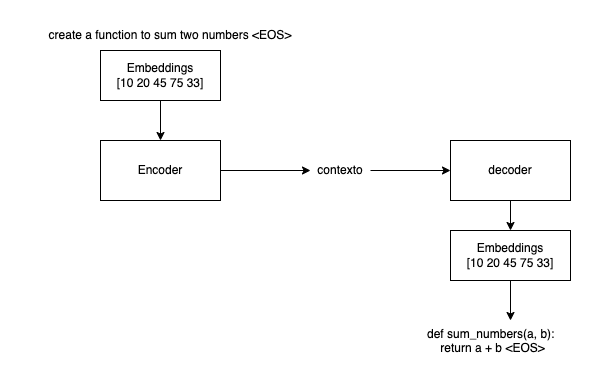


In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.ln = nn.Linear(hidden_size, input_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        #output = self.ln(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, max_length, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

Funções para treinamento

In [ ]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length):
  encoder_hidden = encoder.initHidden()

  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()

  input_length = input_tensor.size(0)
  target_length = target_tensor.size(0)

  encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

  loss = 0

  for ei in range(input_length):
      encoder_output, encoder_hidden = encoder(
          input_tensor[ei], encoder_hidden)
      encoder_outputs[ei] = encoder_output[0, 0]

  decoder_input = torch.tensor([[SOS_token]], device=device)

  decoder_hidden = encoder_hidden

  use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

  if use_teacher_forcing:
      for di in range(target_length):
          decoder_output, decoder_hidden, decoder_attention = decoder(
              decoder_input, decoder_hidden, encoder_outputs)
          loss += criterion(decoder_output, target_tensor[di])
          decoder_input = target_tensor[di]  

  else:
      for di in range(target_length):
          decoder_output, decoder_hidden, decoder_attention = decoder(
              decoder_input, decoder_hidden, encoder_outputs)
          topv, topi = decoder_output.topk(1)
          decoder_input = topi.squeeze().detach()

          loss += criterion(decoder_output, target_tensor[di])
          if decoder_input.item() == EOS_token:
              break

  loss.backward()

  encoder_optimizer.step()
  decoder_optimizer.step()

  return loss.item() / target_length

In [ ]:
import time
import math


def asMinutes(s):
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)


def timeSince(since, percent):
  now = time.time()
  s = now - since
  es = s / (percent)
  rs = es - s
  return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
  #ypoints = np.array([3, 8, 1, 10])

  #plt.plot(ypoints, linestyle = 'dotted')
  #plt.show()
  plt.figure()
  fig, ax = plt.subplots()
  # this locator puts ticks at regular intervals
  loc = ticker.MultipleLocator(base=0.2)
  ax.yaxis.set_major_locator(loc)
  plt.plot(points)
  #plt.show()


In [ ]:
from tqdm import tqdm

def trainIters(encoder, decoder, n_iters, max_length, print_every=1000, plot_every=100, learning_rate=0.01):
  start = time.time()
  plot_losses = []
  print_loss_total = 0
  plot_loss_total = 0

  encoder_optimizer = optim.AdamW(encoder.parameters(), lr=learning_rate)
  decoder_optimizer = optim.AdamW(decoder.parameters(), lr=learning_rate)

  training_pairs = [tensorsFromPair(random.choice(pairs))
                    for i in range(n_iters)]
  criterion = nn.NLLLoss()
  with tqdm(total=100) as pbar:
    for iter in range(1, n_iters + 1):
      training_pair = training_pairs[iter - 1]
      input_tensor = training_pair[0]
      target_tensor = training_pair[1]

      loss = train(input_tensor, target_tensor, encoder,
                  decoder, encoder_optimizer, decoder_optimizer, criterion, max_length)
      print_loss_total += loss
      plot_loss_total += loss
      pbar.update(iter / n_iters * 100)
      
      if iter % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        pbar.set_description('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                      iter, iter / n_iters * 100, print_loss_avg))

      if iter % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0
      if iter % 50000 == 0:
        showPlot(plot_losses)

  print("plot Final!!!")
  showPlot(plot_losses)

In [ ]:
def evaluate(encoder, decoder, sentence, max_length):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
def evaluateRandomly(encoder, decoder, max_length, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0], max_length)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
train_file = "django_train2.csv"
test_file = "django_test2.csv"

input_lang, output_lang, pairs, MAX_LENGTH = prepareData('nl', 'django', train_file, reverse=False)

hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, MAX_LENGTH, dropout_p=0.1).to(device)
#att_decoder_multihead = MultiHeadAttentionLayer( hidden_size, 256, 0.1, device).to(device)
trainIters(encoder1, attn_decoder1, 500000, MAX_LENGTH, print_every=10, learning_rate=0.0003)
#evaluateRandomly(encoder1, attn_decoder1)

maior número: 2775
Counted words:
nl 3670
django 3381


0m 55s (- 469m 0s) (990 0%) 3.9568:  99%|█████████▉| 99.10199999999998/100 [00:22<00:00,  9.50it/s]/usr/local/lib/python3.9/dist-packages/tqdm/std.py:524: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
185m 2s (- 0m 0s) (500000 100%) 0.6381: : 25000050.000000007it [3:04:29, 2258.56it/s]
<ipython-input-10-e1bcf4c81af4>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


plot Final!!!


In [ ]:
train_file = "django_train2.csv"
test_file = "django_test2.csv"

In [ ]:
from torchtext.data.metrics import bleu_score

expected_list = []
model_output_list = []

def bleu(expected, translated):
    return bleu_score(translated, expected)

def evaluatePrecision(test_pairs, encoder, decoder, max_length):
  total_eval = len(test_pairs)
  correct = 0

  with tqdm(total=total_eval) as pbar:
    for i in range(total_eval):
      pair = test_pairs[i]
      output_words, attentions = evaluate(encoder, decoder, pair[0], max_length)
      output_sentence = ' '.join(' '.join(output_words).split()).replace('<EOS>', '')
      model_output_list.append(" ".join(output_sentence.split()))
      result = " ".join(pair[1].split())
      expected_list.append(result)
      pbar.update(i / total_eval * 100)
      pbar.set_description(f'iteracao: {i} / {total_eval}')
      if output_sentence.replace(' ', '').lower() == result.lower().replace(' ', ''):
        correct += 1

  print('total testado: %d' % total_eval)
  print('total correto: %d' % correct)
  print('exact match accuracy: %.2f%%' % (( correct / total_eval) * 100))
  
  return  ( correct / total_eval) * 100

def evaluate_expression(expression, encoder, decoder):
  output_words, attentions = evaluate(encoder, decoder, expression)
  output_sentence = ' '.join(output_words)
  return output_sentence

In [ ]:
from torchtext.data.metrics import bleu_score
from google.colab import drive

params_names = '500k_256hidden__dropout-10percent_adam_0.0003_nolinearenc'

def save_model():
  drive.mount('/content/drive')
  torch.save(encoder1, f'encoder_{params_names}')
  torch.save(attn_decoder1, f'decoder_{params_names}')

def load_test():
    df1 = pd.read_csv(test_file, delimiter=',')

    df1.dropna(inplace=True)
    df1 = df1.reset_index()  # make sure indexes pair with number of rows

    return [[normalizeString(row['nl']), normalizeString(row['code'])] for index, row in df1.iterrows()]

sum_accuracies = 0.0
test_pairs = load_test()
sum_accuracies = evaluatePrecision(test_pairs, encoder1, attn_decoder1, MAX_LENGTH)
print('----------------------------------------')
print(f'parametros: {params_names}')
print('Train dataset: %s, test dataset: %s' % (train_file, test_file))
print('média de acurácia: %.2f%%' % (sum_accuracies))
print('Tamanho dataset %d, tamanho testes: %d' % (len(pairs), len(test_pairs)))
lst = [[item.lower().split(' ')] for item in model_output_list]
lst2 = [item.lower().split(' ') for item in expected_list]

bleu_score_result = bleu_score(lst2, lst)
print('bleu score %.2f' % (bleu_score_result * 100))

#save_model()

iteracao: 1804 / 1805: : 90200.0it [01:04, 1392.66it/s]


total testado: 1805
total correto: 101
exact match accuracy: 5.60%
----------------------------------------
parametros: 500k_256hidden__dropout-10percent_adam_0.0003_nolinearenc
Train dataset: django_train2.csv, test dataset: django_test2.csv
média de acurácia: 5.60%
Tamanho dataset 16000, tamanho testes: 1805
bleu score 1.58


Resultados obtidos e hyperparâmetros utilizados:


parametros: 75k_256hidden__dropout-10percent_adam_0.0003_nolinearenc Train dataset: django_train2.csv, test dataset: django_test2.csv média de acurácia: 33.63% bleu score 22.58

paramentros: 300k_256hidden__dropout-20percent_adam_0.0003_nolinearenc Train dataset: django_train2.csv, test dataset: django_test2.csv média de acurácia: 41.77% bleu score 38.60

parametros: 500k_256hidden__dropout-20percent_adam_0.0003_nolinearenc Train dataset: django_train2.csv, test dataset: django_test2.csv média de acurácia: 44.10% bleu score 40.83

parametros: 500k_256hidden__dropout-10percent_adam_0.0003_nolinearenc Train dataset: django_train2.csv, test dataset: django_test2.csv média de acurácia: 44.10% Tamanho dataset 16000, tamanho testes: 1805 bleu score 42.28

In [ ]:
pairs[123]

['for every f in opts local fields that has an post create sql attribute append f to a list substitute the resulting list for post sql fields ',
 'post sql fields f for f in opts local fields if hasattr f post create sql ']

<ipython-input-69-56a0e5041982>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-69-56a0e5041982>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


input = for every f in opts local fields that has an post create sql attribute append f to a list substitute the resulting list for post sql fields 
output = for self  <EOS>


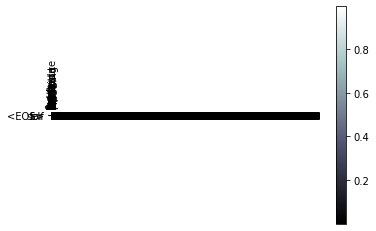

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence, MAX_LENGTH)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("for every f in opts local fields that has an post create sql attribute append f to a list substitute the resulting list for post sql fields ")
